<a href="https://colab.research.google.com/github/HaeSeon/nlp-ner/blob/main/ner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **nltk를 이용한 ner**

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk import word_tokenize, pos_tag, ne_chunk

sentence = "James is working at Disney in London"

# 토큰화와 품사 태깅을 동시 수행
sentence=pos_tag(word_tokenize(sentence))
print(sentence) 


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[('James', 'NNP'), ('is', 'VBZ'), ('working', 'VBG'), ('at', 'IN'), ('Disney', 'NNP'), ('in', 'IN'), ('London', 'NNP')]


In [ ]:
nltk.download('maxent_ne_chunker')
nltk.download('words')
# 개체명 인식
sentence=ne_chunk(sentence)
print(sentence)

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
(S
  (PERSON James/NNP)
  is/VBZ
  working/VBG
  at/IN
  (ORGANIZATION Disney/NNP)
  in/IN
  (GPE London/NNP))


**BIO 표현**
```
강 B-location
남 I-location
으 O
로 O
치 B-food
킨 I-food
먹 O
으 O
러 O
가 O
자 O
```


# **양방향 LSTM을 이용한 개체명 인식**

**데이터**

Conll2003 : 개체명 인식을 위한 전통적인 영어 데이터셋

[다운로드 링크](https://raw.githubusercontent.com/Franck-Dernoncourt/NeuroNER/master/neuroner/data/conll2003/en/train.txt)

데이터
```
[단어] [품사 태깅] [청크 태깅] [개체명 태깅]
EU         NNP         B-NP        B-ORG
rejects    VBZ         B-VP        O
German     JJ          B-NP        B-MISC
call       NN          I-NP        O
to         TO          B-VP        O
boycott    VB          I-VP        O
British    JJ          B-NP        B-MISC
lamb       NN          I-NP        O
. . O O

Peter      NNP         B-NP        B-PER
Blackburn  NNP         I-NP        I-PER
```

+ 품사태깅 : 품사

+ 청크태깅 : ?????

+ 개체명 태깅 : 개체명 (LOC : location, ORG : organization, PER : person, MISC : miscellaneous

+ .. OO 뒤의 공란은 ..OO에서 문장이 끝났음을 의미 (\n)


**데이터 전처리**

In [ ]:
import re
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

In [ ]:
f = open('train.txt', 'r')
tagged_sentences = []
sentence = []

for line in f:
    if len(line)==0 or line.startswith('-DOCSTART') or line[0]=="\n":
        if len(sentence) > 0:
            tagged_sentences.append(sentence)
            sentence = []
        continue
    splits = line.split(' ') # 공백을 기준으로 속성을 구분한다.
    splits[-1] = re.sub(r'\n', '', splits[-1]) # 줄바꿈 표시 \n을 제거한다.
    word = splits[0].lower() # 단어들은 소문자로 바꿔서 저장한다.
    sentence.append([word, splits[-1]]) # 단어와 개체명 태깅만 기록한다.

In [ ]:
print("전체 샘플 개수: ", len(tagged_sentences)) # 전체 샘플의 개수 출력
print(tagged_sentences[0]) # 첫번째 샘플 출력

전체 샘플 개수:  14041
[['eu', 'B-ORG'], ['rejects', 'O'], ['german', 'B-MISC'], ['call', 'O'], ['to', 'O'], ['boycott', 'O'], ['british', 'B-MISC'], ['lamb', 'O'], ['.', 'O']]


이렇게 전처리가 수행된 데이터가 14041개 존재한다.

train을 위해 [('eu', 'B-ORG'), ('rejects', 'O')]가 있다면 ['eu', 'rejects']와 ['B-ORG','O'] 이렇게 두 배열로 저장해야한다.  -> zip()함수

In [ ]:
sentences, ner_tags = [], [] 
for tagged_sentence in tagged_sentences:
    sentence, tag_info = zip(*tagged_sentence) # 각 샘플에서 단어들은 sentence에 개체명 태깅 정보들은 tag_info에 저장.
    sentences.append(list(sentence)) # 각 샘플에서 단어 정보만 저장한다.
    ner_tags.append(list(tag_info)) # 각 샘플에서 개체명 태깅 정보만 저장한다.

In [ ]:
print(sentences[0]) #sentences : 예측을 위한 X
print(ner_tags[0])  #ner_tags : 예측 대상 Y

['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']


In [ ]:
print(sentences[12])
print(ner_tags[12])

['only', 'france', 'and', 'britain', 'backed', 'fischler', "'s", 'proposal', '.']
['O', 'B-LOC', 'O', 'B-LOC', 'O', 'B-PER', 'O', 'O', 'O']


0번 12번 데이터에서 보이듯 샘플 문장들 마다 길이가 다 제각각인 것을 볼 수 있다. 

아래 데이터 분포로 살펴보면 샘플 길이 대부분이 0-40이며, 특히 0-20의 길이를 가진 샘플이 많다는 것을 알 수 있다. 

샘플의 최대 길이 : 113
샘플의 평균 길이 : 14.501887


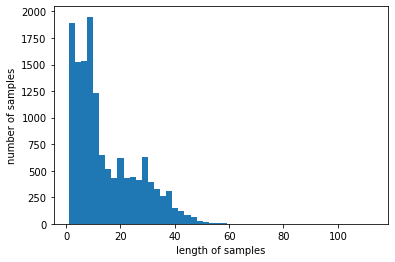

In [ ]:
# 전체 데이터 분포

print('샘플의 최대 길이 : %d' % max(len(l) for l in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

이제 케라스 토크나이저를 통해 토큰화와 정수 인코딩을 한다. 문장 데이터에 있는 모든 단어를 사용하지 않고 높은 빈도수를 가진 상위 4000개의 단어만 사용한다.

+ keras tokenizer : text corpus를 벡터화하는 class
+ fit_on_texts(sentences) : 내부 vocab을 sentence기반으로 업데이트 하는 함수
+ texts_to_sequences(texts) : texts안의 각 text를 정수 시퀀스 형태로 바꾸어주는 함수

In [ ]:
max_words = 4000
# 문장 데이터에 대해서는 src_tokenizer 사용
src_tokenizer = Tokenizer(num_words=max_words, oov_token='OOV')
src_tokenizer.fit_on_texts(sentences)
# 레이블에 해당되는 개체명 태깅 정보에 대해서는 tar_tokenizer 사용
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(ner_tags)

In [ ]:
vocab_size = max_words
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('개체명 태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 4000
개체명 태깅 정보 집합의 크기 : 10


In [ ]:
# 정수 인코딩

# X_train : 문장 데이터에 대해 정수 인코딩이 수행된 결과
X_train = src_tokenizer.texts_to_sequences(sentences)
# Y_train : 개체명 태깅 데이터에 대해서 정수 인코딩이 수행된 결과
y_train = tar_tokenizer.texts_to_sequences(ner_tags)

In [ ]:
print(X_train[0])
print(y_train[0])

[989, 1, 205, 629, 7, 3939, 216, 1, 3]
[4, 1, 7, 1, 1, 1, 7, 1, 1]


현재 문장 데이터에 대해서는 일부 단어가 'OOV'로 대체되어있다. 
+ OOV : Out Of Word (단어 집합에 없는 단어)

이를 확인하기 위해서 다시 디코딩(정수에서 가시 텍스트로 변환) 작업을 해본다.

In [ ]:
# 인덱스로부터 단어를 리턴하는 배열
index_to_word = src_tokenizer.index_word
index_to_ner = tar_tokenizer.index_word

In [ ]:
# 정수 인코딩된 첫번째 문장을 다시 디코딩하는 과정

decoded = []
for index in X_train[0] : # 첫번째 샘플 안의 인덱스들에 대해서
    decoded.append(index_to_word[index]) # 다시 단어로 변환

# 기존문장에는 단어가 있었지만 빈도수가 높은 단어만 사용하였으므로 빈도수가 낮은 단어는 OOV로 대체된것을 볼 수 있다. 
print('기존 문장 : {}'.format(sentences[0]))
print('빈도수가 낮은 단어가 OOV 처리된 문장 : {}'.format(decoded))

기존 문장 : ['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
빈도수가 낮은 단어가 OOV 처리된 문장 : ['eu', 'OOV', 'german', 'call', 'to', 'boycott', 'british', 'OOV', '.']


앞에서 본 문장 길이 그래프에서 대부분의 샘플 길이가 70이내였다. 그러므로 X_train, Y_train 샘플의 길이를 70 정도로 맞추어보자. 이를 위해서 케라스의 pad_swquences()를 사용한다. 

In [ ]:
max_len = 70
# X_train의 모든 샘플들의 길이를 맞출 때 뒤의 공간에 숫자 0으로 채움.
X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
# y_train의 모든 샘플들의 길이를 맞출 때 뒤의 공간에 숫자0으로 채움.
y_train = pad_sequences(y_train, padding='post', maxlen=max_len)

In [ ]:
# 훈련데이터와 테스트 데이터를 8:2 비율로 나눈다. 
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=.2, random_state=777)

In [ ]:
# 레이블에 해당하는 태깅정보 y 에 대해 one-hot 인코딩 수행
y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)

In [ ]:
# 각 데이터에 대한 크기 확인
# ????????????????????????????
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (11232, 70)
훈련 샘플 레이블의 크기 : (11232, 70, 10)
테스트 샘플 문장의 크기 : (2809, 70)
테스트 샘플 레이블의 크기 : (2809, 70, 10)


# **양방향 LSTM(Bi-dictionary LSTM)으로 개체명 인식기 만들기**
+ Embedding layer 추가 : mask_zero = True 추가
+ Bidirectional LSTM layer 추가 : return_sequences = True
+ TimeDistributed layer 추가

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional, TimeDistributed
from keras.optimizers import Adam

In [ ]:
model = Sequential()

# 각 데이터의 길이가 달라서 패딩을 하느라 숫자 0이 많아질 경우에는 Embedding()에 mask_zero=True를 설정
# 숫자 0 은 패딩을 의미하므로 연산에서 제외시킨다는 옵션
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len, mask_zero=True))

# Many-to-Many 문제이므로 LSTM()에 return_sequences=True를 설정
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation='softmax')))


모델 학습

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, batch_size=128, epochs=8,  validation_data=(X_test, y_test))

Epoch 1/8
88/88 [==============================] - 102s 1s/step - loss: 0.2635 - accuracy: 0.7904 - val_loss: 0.1237 - val_accuracy: 0.8333
Epoch 2/8
88/88 [==============================] - 91s 1s/step - loss: 0.1107 - accuracy: 0.8427 - val_loss: 0.0745 - val_accuracy: 0.8895
Epoch 3/8
88/88 [==============================] - 91s 1s/step - loss: 0.0684 - accuracy: 0.9019 - val_loss: 0.0519 - val_accuracy: 0.9253
Epoch 4/8
88/88 [==============================] - 91s 1s/step - loss: 0.0477 - accuracy: 0.9337 - val_loss: 0.0399 - val_accuracy: 0.9440
Epoch 5/8
88/88 [==============================] - 90s 1s/step - loss: 0.0359 - accuracy: 0.9486 - val_loss: 0.0357 - val_accuracy: 0.9492
Epoch 6/8
88/88 [==============================] - 89s 1s/step - loss: 0.0296 - accuracy: 0.9585 - val_loss: 0.0328 - val_accuracy: 0.9545
Epoch 7/8
88/88 [==============================] - 89s 1s/step - loss: 0.0245 - accuracy: 0.9649 - val_loss: 0.0322 - val_accuracy: 0.9555
Epoch 8/8
88/88 [=========

In [ ]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

88/88 [==============================] - 11s 125ms/step - loss: 0.0310 - accuracy: 0.9578

 테스트 정확도: 0.9578


앞서 만들어둔 인덱스로부터 단어와 개체명 태깅 정보를 리턴하는 index_to_word와 index_to_ner를 사용하여 테스트 데이터에 대한 예측값과 실제값을 비교

In [ ]:
i=10 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = model.predict(np.array([X_test[i]])) # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = np.argmax(y_predicted, axis=-1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.
true = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for w, t, pred in zip(X_test[i], true, y_predicted[0]):
    if w != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[w], index_to_ner[t].upper(), index_to_ner[pred].upper()))

단어             |실제값  |예측값
-----------------------------------
sarah            : B-PER   B-PER
brady            : I-PER   I-PER
,                : O       O
whose            : O       O
republican       : B-MISC  B-MISC
husband          : O       O
was              : O       O
OOV              : O       O
OOV              : O       O
in               : O       O
an               : O       O
OOV              : O       O
attempt          : O       O
on               : O       O
president        : O       O
ronald           : B-PER   B-PER
reagan           : I-PER   I-PER
,                : O       O
took             : O       O
centre           : O       O
stage            : O       O
at               : O       O
the              : O       O
democratic       : B-MISC  B-MISC
national         : I-MISC  I-MISC
convention       : I-MISC  I-MISC
on               : O       O
monday           : O       O
night            : O       O
to               : O       O
OOV              : O       O
pre

정확도가 높게 나왔지만 대부분의 단어가 개체명이 아니라는 'O'가 태깅된 상황에서 예측 정확도가 수많은 'O'로 인해 결정되고 있기 때문에 적절하지 않은 정확도 측정법이다. 

이를 해결하기 위해 F1-score를 도입할 수 있다. 

# **양방향 LSTM을 이용한 개체명 인식 + F1-score**

In [ ]:
!pip install tensorflow==1.14.0
!pip install keras==2.2.4
!pip install tensorflow-gpu==1.14.0

     |████████████████████████████████| 109.3MB 91kB/s 
     |████████████████████████████████| 3.2MB 46.2MB/s 
     |████████████████████████████████| 491kB 40.2MB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1


     |████████████████████████████████| 317kB 8.2MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


     |████████████████████████████████| 377.1MB 45kB/s 


In [ ]:
# for using CRF
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-cnyc3u73
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-cnyc3u73
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp37-none-any.whl size=101065 sha256=8af2fdc8731c9e93701cafd09d5941abc14cdc81b0d1a121f5b0a1def6e2c61a
  Stored in directory: /tmp/pip-ephem-wheel-cache-mp259l0f/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


**개체명 인식 데이터에 대한 이해와 전처리**

이번에는 양방향 LSTM과 CRF를 함께 사용하여 앞에서 사용한 데이터 외에 다른 데이터를 사용하여 개체명 인식을 수행해볼것이다. 

[데이터 다운로드](https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus)

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [ ]:
data = pd.read_csv("ner_dataset.csv", encoding="latin1")

In [ ]:
data[:5]

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


이번 데이터는 하나의 문장을 여러개의 행으로 나누어놓았다. 
이는 뒤에서 Pandas의 fillna를 통해 하나로 묶는 작업을 할 것이다. 

In [ ]:
print('데이터프레임 행의 개수 : {}'.format(len(data)))

데이터프레임 행의 개수 : 362197


In [ ]:
print('데이터에 Null 값이 있는지 유무 : ' + str(data.isnull().values.any()))

데이터에 Null 값이 있는지 유무 : True
